<a href="https://colab.research.google.com/github/fjme95/aplicaciones-financieras/blob/main/Modulo%202/Semana%202/Predicci%C3%B3n_de_cambio_en_la_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [ ]:
!pip install -U plotly

     |████████████████████████████████| 26.5 MB 1.7 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import plotly.express as px
import plotly.io as pio

In [ ]:
pio.templates.default = 'plotly_white'

np.random.seed(100)

# Datos

Los datos son de opciones de tipo call en S&P 500 entre 2014 y 2019. Por día se tomó una muestra aleatoria de 100 opciones y se guardaron los precios spot del activo subyacente en el día de la muestra y al día siguiente.

La variable objetivo es el cambio en la volatilidad implícita.

In [ ]:
iv_data_raw = pd.read_csv('https://raw.githubusercontent.com/fjme95/aplicaciones-financieras/main/Modulo%202/Semana%202/data/Implied_Volatility_Data_vFinal.csv')
iv_data_raw

,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change
0,20140630,0.006678,0.184,0.745927,0.008462
1,20140630,0.006678,2.252,0.286911,0.002024
2,20140630,0.006678,0.124,0.902941,0.019707
3,20140630,0.006678,2.144,0.910926,0.006424
4,20140630,0.006678,1.412,0.885760,0.005673
...,...,...,...,...,...
125695,20190626,0.003823,0.228,0.265052,-0.000778
125696,20190626,0.003823,0.144,0.943591,0.016969
125697,20190626,0.003823,0.060,0.148294,-0.001713
125698,20190626,0.003823,0.340,0.917499,0.006153


In [ ]:
iv_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125700 entries, 0 to 125699
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       125700 non-null  int64  
 1   SPX Return                 125700 non-null  float64
 2   Time to Maturity in Year   125700 non-null  float64
 3   Delta                      125700 non-null  float64
 4   Implied Volatility Change  125700 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 4.8 MB


Transformamos la variable ```Date``` de numérica a fecha.

In [ ]:
iv_data = iv_data_raw.copy()
iv_data.Date = iv_data_raw.Date.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
iv_data

,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change
0,2014-06-30,0.006678,0.184,0.745927,0.008462
1,2014-06-30,0.006678,2.252,0.286911,0.002024
2,2014-06-30,0.006678,0.124,0.902941,0.019707
3,2014-06-30,0.006678,2.144,0.910926,0.006424
4,2014-06-30,0.006678,1.412,0.885760,0.005673
...,...,...,...,...,...
125695,2019-06-26,0.003823,0.228,0.265052,-0.000778
125696,2019-06-26,0.003823,0.144,0.943591,0.016969
125697,2019-06-26,0.003823,0.060,0.148294,-0.001713
125698,2019-06-26,0.003823,0.340,0.917499,0.006153


# Predicción del cambio en la volatilidad implícita

Separamos las variables predictoras de la variable objetivo

In [ ]:
X = iv_data.drop(columns = ['Date', 'Implied Volatility Change'])
y = iv_data['Implied Volatility Change']

In [ ]:
X

,SPX Return,Time to Maturity in Year,Delta
0,0.006678,0.184,0.745927
1,0.006678,2.252,0.286911
2,0.006678,0.124,0.902941
3,0.006678,2.144,0.910926
4,0.006678,1.412,0.885760
...,...,...,...
125695,0.003823,0.228,0.265052
125696,0.003823,0.144,0.943591
125697,0.003823,0.060,0.148294
125698,0.003823,0.340,0.917499


In [ ]:
y

0         0.008462
1         0.002024
2         0.019707
3         0.006424
4         0.005673
            ...   
125695   -0.000778
125696    0.016969
125697   -0.001713
125698    0.006153
125699   -0.000285
Name: Implied Volatility Change, Length: 125700, dtype: float64

## Creación de variables para regresión

Como punto de referencia, usaremos una Regresión Lineal. El modelo seguirá el sugerido por Hull y White en 2017, a saber, 

$$
\mathbb{E}\left( \Delta IV \right) = R \frac{a+b\delta+c\delta^2}{\sqrt{T}},
$$

donde $R$ es el rendimiento del activo subyacente, $T$ es el tiempo de la opción para la maduración, $\delta$ es el *moneyness* de la opción y $a$, $b$, y $c$ son constantes que estimaremos con la regresión lineal.

In [ ]:
X['x1'] = X['SPX Return'] / np.sqrt(X['Time to Maturity in Year'])
X['x2'] = X['SPX Return'] / np.sqrt(X['Time to Maturity in Year']) * X['Delta']
X['x3'] = X['x2'] * X['Delta']

In [ ]:
X

,SPX Return,Time to Maturity in Year,Delta,x1,x2,x3
0,0.006678,0.184,0.745927,0.015568,0.011612,0.008662
1,0.006678,2.252,0.286911,0.004450,0.001277,0.000366
2,0.006678,0.124,0.902941,0.018964,0.017123,0.015461
3,0.006678,2.144,0.910926,0.004561,0.004154,0.003784
4,0.006678,1.412,0.885760,0.005620,0.004978,0.004409
...,...,...,...,...,...,...
125695,0.003823,0.228,0.265052,0.008007,0.002122,0.000562
125696,0.003823,0.144,0.943591,0.010075,0.009507,0.008970
125697,0.003823,0.060,0.148294,0.015608,0.002315,0.000343
125698,0.003823,0.340,0.917499,0.006557,0.006016,0.005519


Definimos las variables que vamos a ocupar en la regresión y las que ocuparemos con las redes neuronales.

In [ ]:
X_regression_cols = ['x1', 'x2', 'x3']
X_nn_cols = ['SPX Return', 'Time to Maturity in Year', 'Delta']

## División en conjuntos de entrenamiento, validación y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = .75, random_state = 10)

print('Dimensiones de:')
print('\tTrain:', X_train.shape, y_train.shape)
print('\tValidation:', X_val.shape, y_val.shape)
print('\tTest:', X_test.shape, y_test.shape)

Dimensiones de:
	Train: (75420, 6) (75420,)
	Validation: (25140, 6) (25140,)
	Test: (25140, 6) (25140,)


## Regresión

### Creación

Ocupamos un [```ColumnTransformer```](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) para normalizar las columnas para la regresión y eliminar las restantes. Éste entrará en un [```Pipeline```](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) que combina la transformaciones y pone un estimador final.

In [ ]:
transformer = ColumnTransformer(
    [
     ('transformador', StandardScaler(), X_regression_cols)
    ]
)

pipe = Pipeline(
    [
     ('procesamiento', transformer), 
     ('modelo', LinearRegression())
    ]
)

### Entrenamiento

Entrenamos el modelo con los datos de entrenamiento. El ```ColumnTransformer``` que hicimos garantiza que sólo ocupemos las variables $x1$, $x2$ y $x3$.

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('procesamiento',
                 ColumnTransformer(transformers=[('transformador',
                                                  StandardScaler(),
                                                  ['x1', 'x2', 'x3'])])),
                ('modelo', LinearRegression())])

Vemos los valores de $a$, $b$ y $c$, respectivamente.

In [ ]:
pipe.named_steps['modelo'].intercept_

0.0003200564173959162

### Predicción

Usamos ```predict``` para obtener las predicciones del modelo en train y test.

In [ ]:
y_train_linreg = pipe.predict(X_train)
y_test_linreg = pipe.predict(X_test)

### Métricas

Calculamos el error cuadrático medio (MSE) y el error absoluto medio (MAE) con [```mean_squared_error```](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) y [```mean_absolute_error```](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html),

In [ ]:
mse_test_linreg = mean_squared_error(y_test, y_test_linreg)

print(
    f'MSE train: {mean_squared_error(y_train, y_train_linreg)}', 
    f'MSE test: {mse_test_linreg}', 
    '', 
    f'MAE train: {mean_absolute_error(y_train, y_train_linreg)}', 
    f'MAE test: {mean_absolute_error(y_test, y_test_linreg)}', 
    sep = '\n'
)

MSE train: 7.7568985022962e-05
MSE test: 8.32727353927234e-05

MAE train: 0.0051857406840985255
MAE test: 0.005261575109865606


Ocuparemos el MSE para comparar. El MAE únicamente está para ver la escala de la media de los errores.

## Red Neuronal


La red neuronal con la que probaremos tiene una capa de normalización (z-scores), dos capas densas con 20 neuronas cada una y función activación sigmoide y una capa de salida con una neurona (función de activación lineal).

Se minimizará el MSE con el optimizador ADAM y se hará seguimiento al MAE durante cada época del entrenamiento.

### Creación

In [ ]:
model = keras.models.Sequential(
    [
     layers.Input((3, )), 
     layers.Normalization(), 
     layers.Dense(20, activation = 'sigmoid'), 
     layers.Dense(30, activation = 'sigmoid'), 
     layers.Dense(20, activation = 'sigmoid'), 
     layers.Dense(1)
    ]
)

model.compile(
    loss = 'mse', 
    optimizer = keras.optimizers.Adam()
)

# model.compile(
#     loss = keras.losses.MeanSquaredError(), 
#     optimizer = keras.optimizers.Adam()
# )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 20)                80        
                                                                 
 dense_1 (Dense)             (None, 30)                630       
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,358
Trainable params: 1,351
Non-trainable params: 7
______________________________________________________

Creamos [callbacks](https://keras.io/api/callbacks/). Estos son objetos que realizan acciones durante varias etapas del entrenamiento (e.g. al inicio o fin de cada época, antes o después de cada lote, etc).

En particular, usaremos:
- [```ModelCheckpoint```](https://keras.io/api/callbacks/model_checkpoint/): Lo ocuparemos para guardar los pesos del mejor modelo cada que termine una época.
- [```EarlyStopping```](https://keras.io/api/callbacks/early_stopping/): Nos ayudará a detener el entrenamiento después de que no haya visto mejoría en la pérdida del cojunto de validación durante 1000 épocas.

In [ ]:
# Este callback guardará los pesos del mejor modelo durante el entrenamiento.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'modelo_volatilidad_implicita.h5', 
    save_best_only = True
)

# Este ayuda a detener el entrenamiento si no hay mejoría con la épocas.
# Además, carga el mejor modelo una vez que termina el entrenamiento.
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience = 500, 
    restore_best_weights = True
)

### Entrenamiento

In [ ]:
history = model.fit(
    X_train[X_nn_cols], y_train, 
    epochs = 30000, 
    batch_size = 256, 
    validation_data = (X_val[X_nn_cols], y_val), 
    callbacks = [checkpoint_cb, early_stopping_cb]
)

Epoch 1/30000
295/295 [==============================] - 3s 4ms/step - loss: 2.4708e-04 - val_loss: 9.2895e-05
Epoch 2/30000
295/295 [==============================] - 1s 4ms/step - loss: 8.8166e-05 - val_loss: 9.2494e-05
Epoch 3/30000
295/295 [==============================] - 1s 4ms/step - loss: 8.7966e-05 - val_loss: 9.1265e-05
Epoch 4/30000
295/295 [==============================] - 1s 4ms/step - loss: 8.7536e-05 - val_loss: 9.0713e-05
Epoch 5/30000
295/295 [==============================] - 1s 4ms/step - loss: 8.7923e-05 - val_loss: 9.3311e-05
Epoch 6/30000
295/295 [==============================] - 1s 4ms/step - loss: 8.6886e-05 - val_loss: 8.9234e-05
Epoch 7/30000
295/295 [==============================] - 1s 4ms/step - loss: 8.6264e-05 - val_loss: 8.9669e-05
Epoch 8/30000
295/295 [==============================] - 1s 4ms/step - loss: 8.5728e-05 - val_loss: 8.8432e-05
Epoch 9/30000
295/295 [==============================] - 1s 4ms/step - loss: 8.5590e-05 - val_loss: 8.7986e-05
E

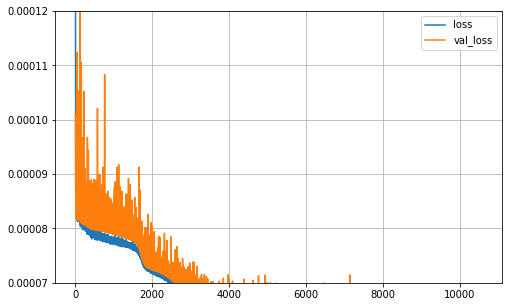

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.00007,0.00012)
plt.show()

### Métricas

In [ ]:
mse_test_nn = model.evaluate(X_test[X_nn_cols],y_test, verbose = 0)
print(f'MSE test: {mse_test_nn}')

MSE test: 6.837067485321313e-05


In [ ]:
y_pred_nn = model.predict(X_test[X_nn_cols])

## Ganancia de la red neuronal



In [ ]:
print(f'Ganancia: {1 - mse_test_nn/mse_test_linreg}')

Ganancia: 0.17895485802442435


# Ligas

1. Sobre el modelo propuesto por Hull & White. página 9: http://www-2.rotman.utoronto.ca/~hull/DownloadablePublications/Optimal%20Delta%20Hedging.pdf